In [7]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
import scipy

# JPEG Algo

Image shape: (4000, 6016, 3)
Image data type: uint8
Theoretical uncompressed image size: 68.85 MB


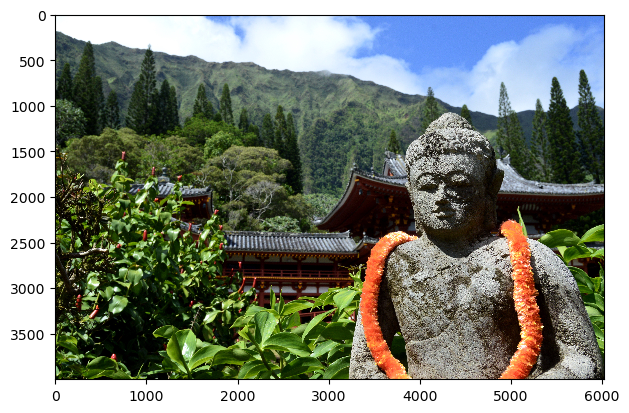

In [8]:
img = skio.imread("monk.jpg")
skio.imshow(img)

print(f'Image shape: {img.shape}')
print(f'Image data type: {img.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(img.shape)) / (1024 ** 2),2)} MB')

In [117]:
# given an image, return image in YCbCr color space
# instead of red, green, blue channels, one brightness channel and two channels indicating deviation in blue and red respectively
# conversion taken from [wikipedia](https://en.wikipedia.org/wiki/YCbCr)
# according to ITU-R BT.709 convension
def rgb_to_YCbCr(img):
    # ITU-R BT.709 RGB to YCbCr conversion matrix
    conv_matrix = np.matrix('0.2126 0.7152 0.0722; -0.1146 -0.3854 0.5; 0.5 -0.4542 -0.0458')

    other_matrix = np.matrix('0.2126 0.7152 0.0722; -0.1146 -0.3854 0.5; 0.5 -0.4542 -0.0458')

    # reshape to do matrix multiplication across color channels easier
    img_reshape = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))

    # do matrix multiplication to switch color spaces
    converted_reshaped = img_reshape * np.transpose(conv_matrix)
    # go back to original shape
    converted = np.reshape(np.asarray(converted_reshaped), img.shape)

    return converted

In [115]:
def YCbCr_to_rgb(img):
    conv_matrix = np.matrix('1 0 1.5748; 1 -0.1873 -0.4681; 1 1.8556 0')

    other_matrix = np.matrix('0.2126 0.7152 0.0722; -0.1146 -0.3854 0.5; 0.5 -0.4542 -0.0458')
    conv_matrix = np.linalg.inv(other_matrix)
    
    # reshape to do matrix multiplication across color channels easier
    img_reshape = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))

    # do matrix multiplication to switch color spaces
    before_rounding = img_reshape * np.transpose(conv_matrix)

    range = before_rounding.max() - before_rounding.min()
    before_rounding -= before_rounding.min()
    before_rounding /= range
    
    # go back to original shape
    converted = np.reshape(np.asarray(before_rounding), img.shape)

    return converted
    

In [114]:
# returns a tuple of arrays: first is brightness, second and third are the downscaled colors 
# could be in some sort of object later to store all information
# 4:2:0  - this one 
# 4:2:2 
def downscale_colors(img):
    Y = img[:, :, 0]
    Cb = img[::2, ::2, 1]
    Cr = img[::2, ::2, 2]

    return (Y, Cb, Cr)

In [113]:
# there are definitely some random color artifacts

def reconstruct_downscaled(img_tuple):
    Y = img_tuple[0]
    # fill out 2x2 squares with downsampled value
    Cb = np.repeat(np.repeat(img_tuple[1], 2, axis=1), 2, axis=0)
    Cr = np.repeat(np.repeat(img_tuple[2], 2, axis=1), 2, axis=0)

    wrong_order = [Y, Cb, Cr]

    img = np.transpose(wrong_order, axes=(1,2,0))

    return img

In [112]:
from skimage.util import view_as_blocks

def form_blocks(img_tuple, block_size = 8):

    blocked_by_color = []
    for img in img_tuple:
        blocked_by_color.append(view_as_blocks(img, (block_size, block_size)))

    return blocked_by_color

In [109]:
def reconstruct_blocks(blocked_img, block_size = 8):
    Y_shape = (blocked_img[0].shape[0] * block_size, blocked_img[0].shape[1] * block_size)
    C_shape = (Y_shape[0] // 2, Y_shape[1] // 2)
    Y = blocked_img[0].reshape(Y_shape)
    Cb = blocked_img[1].reshape(C_shape)
    Cr = blocked_img[2].reshape(C_shape)

    return (Y, Cb, Cr)

In [128]:
def calculate_blocked_dct(blocked_img):
    blocked_img[0] -= 128 # want the whole thing centered at 0
    blocked_img[1] -= 128 # want the whole thing centered at 0
    blocked_img[2] -= 128 # want the whole thing centered at 0

    dct_array = []
    for img in blocked_img:
        dct_array.append(scipy.fftpack.dctn(img, axes=(-2,-1)))
    
    return dct_array

In [133]:
def inverse_block_dct(dct_img):
    blocked_img = []
    for img in dct_img:
        blocked_img.append(scipy.fftpack.idctn(img, axes=(-2,-1)))
    
    blocked_img[0] -= 128 # want the whole thing centered at 0
    blocked_img[1] -= 128 # want the whole thing centered at 0
    blocked_img[2] -= 128 # want the whole thing centered at 0

    return blocked_img

In [135]:
def quantize(img_tuple, quality):
    # as specified in JPEG standard
    default = np.array([
    [6, 4, 4, 6, 10, 16, 20, 24],
    [5, 5, 6, 8, 10, 23, 24, 22],
    [6, 5, 6, 10, 16, 23, 28, 22],
    [6, 7, 9, 12, 20, 35, 32, 25],
    [7, 9, 15, 22, 27, 44, 41, 31],
    [10, 14, 22, 26, 32, 42, 45, 37],
    [20, 26, 31, 35, 41, 48, 48, 40],
    [29, 37, 38, 39, 45, 40, 41, 40]
    ])

    q = 1 / default
    quantized_tuple = []
    for img in img_tuple:
        
        result = img * q[np.newaxis, np.newaxis, :, :]
        quantized_tuple.append(result)

    return result

In [ ]:
def dequantize(img_tuple, quality):

In [120]:
def jpeg_compress(img):
    img_ybr = rgb_to_YCbCr(img)
    downscaled = downscale_colors(img_ybr)
    blocked = form_blocks(downscaled)
    dct = calculate_blocked_dct(blocked)

    return dct

In [119]:
def jpeg_decompress(img):
    idct = img
    blocked = inverse_block_dct(idct)
    unblocked = reconstruct_blocks(blocked)
    reconstructed_down = reconstruct_downscaled(downscaled)
    reconstructed_image = YCbCr_to_rgb(reconstructed_down)
    return reconstructed_image

Text(0.5, 1.0, 'Reconstruction')

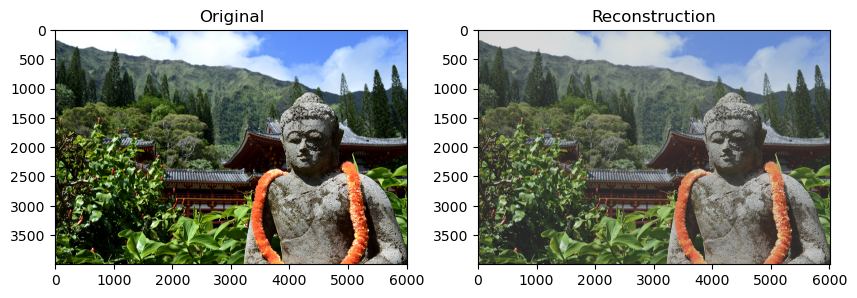

In [132]:
compressed = jpeg_compress(img)
decompressed = jpeg_decompress(compressed)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(10)

axs[0].imshow(img)
axs[0].set_title("Original")

axs[1].imshow(decompressed)
axs[1].set_title("Reconstruction")
    

0.0
1.0
[251 255 255]
[0.84239847 0.85343689 0.85343762]


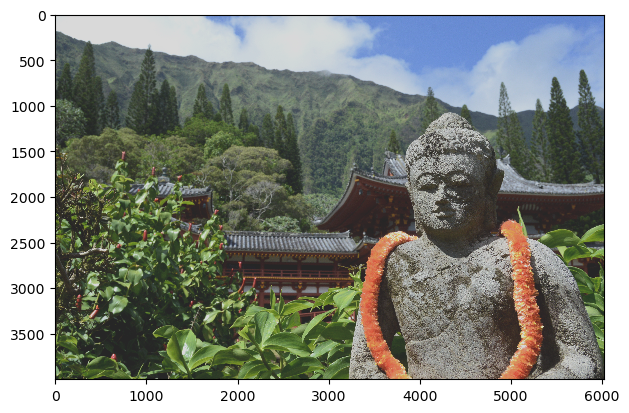

In [198]:
reconstructed_down = reconstruct_downscaled(downscaled)
reconstructed_image = YCbCr_to_rgb(reconstructed_down)

#print(img[0][0])
#print(reconstructed_image[0][0])

skio.imshow(reconstructed_image)

In [9]:
from skimage.color import rgb2ycbcr, ycbcr2rgb
skimage_ybr = rgb2ycbcr(img)
skimage_downscaled = downscale_colors(skimage_ybr)
skimage_rescaled = reconstruct_downscaled(skimage_downscaled)
skimage_reconstructed = ycbcr2rgb(skimage_rescaled)

skio.imshow(skimage_reconstructed[3550:3600,850:925,:], interpolation = "none")

NameError: name 'downscale_colors' is not defined

Text(0.5, 1.0, 'Reconstruction')

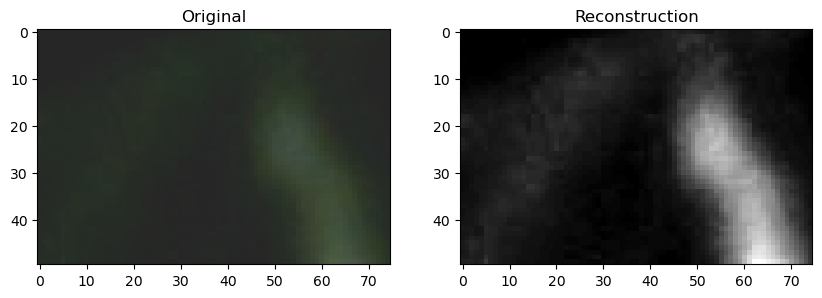

In [200]:
sample = reconstructed_image[3550:3600,850:925,:]
single_color = reconstructed_down[3550:3600,850:925, 0]

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(10)

axs[0].imshow(sample)
axs[0].set_title("Original")

axs[1].imshow(single_color, cmap = "gray")
axs[1].set_title("Reconstruction")
    

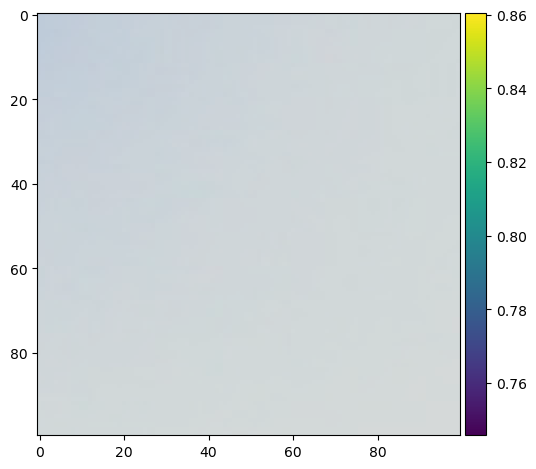

In [201]:
sample = reconstructed_image[100:200, 2500:2600, :]
skio.imshow(sample)

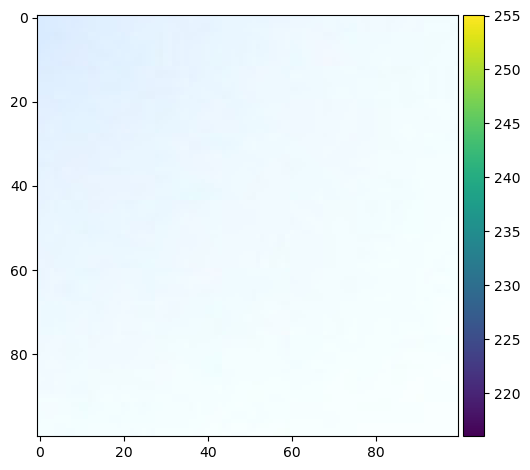

In [202]:
sample = img[100:200, 2500:2600, :]
skio.imshow(sample)

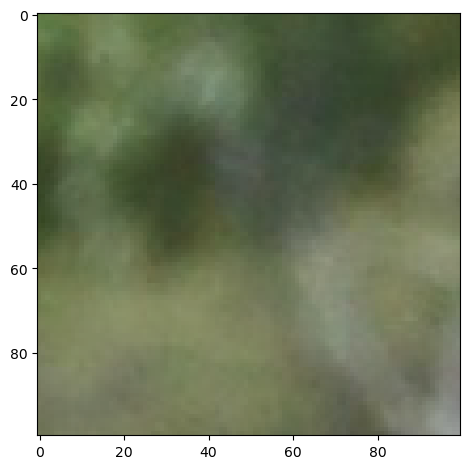

In [203]:
sample = reconstructed_image[1500:1600, 1750:1850, :]
skio.imshow(sample)

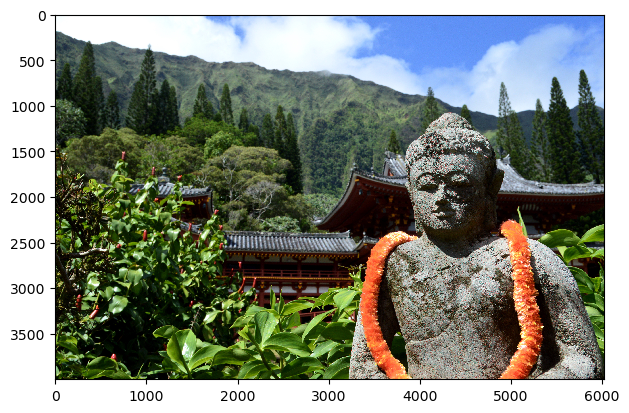

In [204]:
just_downsample = downscale_colors(img)
just_downsample_reconstruction = reconstruct_downscaled(just_downsample)
skio.imshow(just_downsample_reconstruction)